In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)  # Show all columns

# Optional: Set the display width to ensure all columns fit in the view
pd.set_option('display.width', 1000)

df = pd.read_csv('col_and_weather2.csv')

C:\Users\dougl\AppData\Local\Temp\ipykernel_6256\1801796490.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('col_and_weather2.csv')


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264959 entries, 0 to 1264958
Columns: 121 entries, Unnamed: 0.1 to wind_spd
dtypes: bool(2), float64(17), int64(37), object(65)
memory usage: 1.1+ GB
None


In [4]:
df['HAS_FATALITY'].value_counts()

HAS_FATALITY
0    1263022
1       1937
Name: count, dtype: int64

# Dropping Unnecessary columns/ information

# Duplicate 2023

I noticed while doing EDA that 2023 had an alarmingly high number of instance in just about every category. By doing a manual check online to see how many total deaths there were, google reported that there were 259 (where as that dataset indicated there were 518) This lead to the hypothesis that there were duplicate rows in the dataframe and would need to be handled accordingly. 

In [5]:
# Convert the CRASH DATE column to datetime format if it isn't already
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Filter the DataFrame for crashes that occurred in 2023
df_2023 = df[df['CRASH DATE'].dt.year == 2023]

# Check for duplicates
duplicates = df_2023[df_2023.duplicated()]

# Display the number of duplicate rows
print(f"Number of duplicate rows in 2023 data: {len(duplicates)}")

# Optionally, display the duplicate rows to investigate
if not duplicates.empty:
    print(duplicates)

Number of duplicate rows in 2023 data: 0


In [6]:
# Remove duplicates from the data
df = df.drop_duplicates()

In [7]:
df.info

<bound method DataFrame.info of          Unnamed: 0.1  Unnamed: 0  COLLISION_ID CRASH DATE CRASH TIME  CRASH HOUR  CRASH DAY  CRASH WEEK  CRASH MONTH CRASH SEASON  is_weekend  is_holiday holiday_name   LATITUDE  LONGITUDE                     ROAD        NEIGHBOURHOOD        BOROUGH  ZIP CODE      CLUSTER NAME  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  NUMBER OF MOTORIST KILLED  VEHICLE_COUNT_ESTIMATE  HAS_FATALITY  HAS_INJURY  HAS_FATALITY_OR_INJURY  CONTRIBUTING FACTOR VEHICLE 1 CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3 CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5 DRIVER_LICENSE_STATUS_1 DRIVER_LICENSE_STATUS_2 DRIVER_LICENSE_STATUS_3 DRIVER_LICENSE_STATUS_4 DRIVER_LICENSE_STATUS_5 DRIVER_SEX_1 DRIVER_SEX_2 DRIVER_SEX_3 DRIVER_SEX_4 DRIVER_SEX_5         POINT_OF_IMPACT_1          POINT_OF_IMPACT_2 POIN

## GeoCoding Error

In [8]:
# Specify the values of interest
values_of_interest = [
    'Brooklyn',
    'Queens County',
    'Manhattan',
    'The Bronx',
    'Staten Island',
    'Queens',
    'Kings County'
]

# Filter rows where SUBURB is not in values_of_interest
dougs_booboo = df[~df['BOROUGH'].isin(values_of_interest)]
dougs_booboo.shape

(0, 121)

Doug's booboo currently contains all of the values that don't fit into appropriate suburbs, even the ones that aren't corrupted but simply didn't contain enough information to pass geocoding (values the longitude and latitude couldn't be salvaged.) To get a better idea of just how much damage this booboo caused we must first filter out the values with nan in longitude and latitude.

Since the set of columns missing longitude is identical to that of latitude we can simply drop one or the other.

In [9]:
dougs_booboo = dougs_booboo.dropna(subset=['LATITUDE'])
dougs_booboo.shape

(0, 121)

Ultimately 15525 of the roughly 50,000 values that geolocating retrieved coordinates for where corrupted in some sense. Not as tragic of a loss as I originally suspected. Since there was effectively no data lost, as the results of the geolocating were added as new columns as opposed to overwriting the original columns we have options in regards to how we correct this error. Given the time constraints however we will simply dispose of the incorrect values as the effect on the model should be relatively minor given the total size of the dataset.

In [10]:
eyesore = dougs_booboo['BOROUGH'].value_counts()
eyesore.head(200)

Series([], Name: count, dtype: int64)

In [11]:
eyesore.shape

(0,)

So now we make the entirety of Doug's boo boo dissapear.

In [12]:
# Create a mapping for the values to be merged
suburb_mapping = {
    'Kings County': 'Brooklyn',
    'Queens County': 'Queens'
}

# Replace the values in the 'SUBURB' column based on the mapping
df['BOROUGH'] = df['BOROUGH'].replace(suburb_mapping)

In [13]:
# Specify the values of interest
values_of_interest = [
    'Brooklyn',
    'Queens County',
    'Manhattan',
    'The Bronx',
    'Staten Island',
    'Queens',
    'Kings County'
]

# Filter rows where SUBURB is in values_of_interest
df = df[df['BOROUGH'].isin(values_of_interest)]
df.shape

(1264959, 121)

In [14]:
df['BOROUGH'].value_counts()

BOROUGH
Brooklyn         392766
Queens           362979
Manhattan        241887
The Bronx        205275
Staten Island     62052
Name: count, dtype: int64

In [15]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'COLLISION_ID', 'CRASH DATE', 'CRASH TIME', 'CRASH HOUR', 'CRASH DAY', 'CRASH WEEK', 'CRASH MONTH', 'CRASH SEASON',
       ...
       'solar_rad', 't_dhi', 't_dni', 't_ghi', 't_solar_rad', 'temp', 'ts', 'wind_dir', 'wind_gust_spd', 'wind_spd'], dtype='object', length=121)

In addition to those values theres a few more that have no values whatsoever to our dataset, yet the column name is misleading. One would think a cars year would reflect the condition its in, with advances in technology making newer cars less likely to be involved in accidents. However all of the values for year are unknown of nan, as showcased below.

In [16]:
print(df.isnull().sum())

Unnamed: 0.1                           0
Unnamed: 0                             0
COLLISION_ID                           0
CRASH DATE                             0
CRASH TIME                             0
CRASH HOUR                             0
CRASH DAY                              0
CRASH WEEK                             0
CRASH MONTH                            0
CRASH SEASON                           0
is_weekend                             0
is_holiday                             0
holiday_name                     1232907
LATITUDE                               0
LONGITUDE                              0
ROAD                                2398
NEIGHBOURHOOD                     436627
BOROUGH                                0
ZIP CODE                               0
CLUSTER NAME                           0
NUMBER OF PERSONS INJURED              0
NUMBER OF PERSONS KILLED               0
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIS

# Last Minute Features

## Adding Month, Week and Season Features

In [17]:
# Assuming 'CRASH DATE' is your date column and it's in datetime format
# If not, convert it to datetime first
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Extract month
df['CRASH MONTH'] = df['CRASH DATE'].dt.month

# Extract week of the year
df['CRASH WEEK'] = df['CRASH DATE'].dt.isocalendar().week

# Define a function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a 'SEASON' column
df['SEASON'] = df['CRASH MONTH'].apply(get_season)

In [18]:
# Ensure CRASH DATE is in datetime format
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Binarizing Killed and Injured Columns

In [19]:
df['HAS_FATALITY'] = (df['NUMBER OF PERSONS KILLED'] > 0).astype(int)
df['HAS_INJURY'] = (df['NUMBER OF PERSONS INJURED'] > 0).astype(int)

Now we essentially combine the two to create a boolean indicator whether anyone was hurt or injured. The speculation behind this decision is that any accident in which an injury was caused is likely to have the potential to kill. The added benefit is that individually each feature is an outlier, by binarizing and combining we make it less of an outlier.

In [20]:
df['HAS_FATALITY_OR_INJURY'] = ((df['NUMBER OF PERSONS KILLED'] > 0) | (df['NUMBER OF PERSONS INJURED'] > 0)).astype(int)

In [21]:
df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

CONTRIBUTING FACTOR VEHICLE 1
improper driving technique       348093
driver distraction/impairment    327522
unspecified                      306411
traffic rule violation           142747
external distraction/obstacle     75876
poor road conditions              29056
alcohol/drug use                  17995
vehicle defect                    10940
electronics use                    1067
police chase                         70
Name: count, dtype: int64

# Time Series 

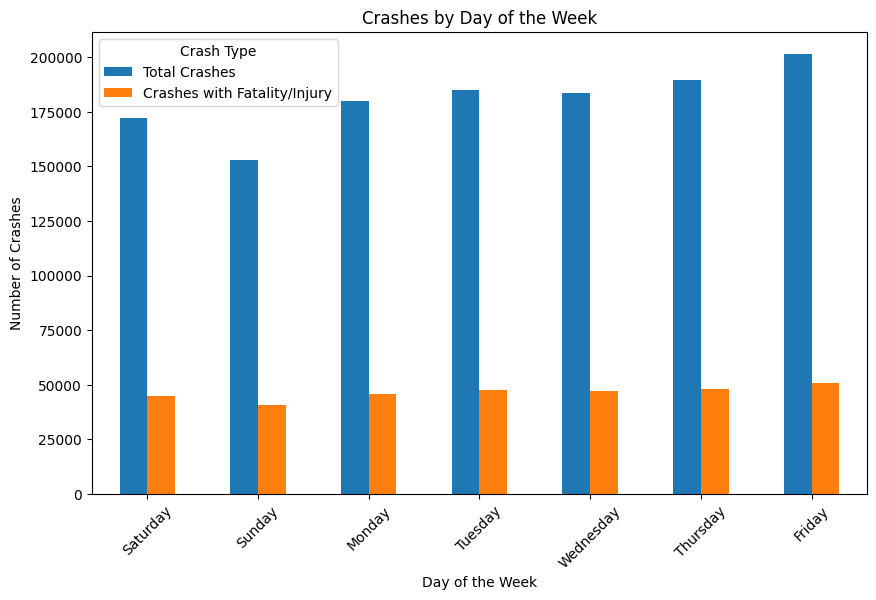

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Specify the desired order of days
ordered_days = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Count crashes per day of the week
day_counts = df['CRASH DAY'].value_counts().reindex(ordered_days)

# Count crashes with fatalities or injuries per day of the week
fatal_injury_counts = df[df['HAS_FATALITY_OR_INJURY'] == 1]['CRASH DAY'].value_counts().reindex(ordered_days)

# Combine the data into a DataFrame for easier plotting
counts_df = pd.DataFrame({
    'Total Crashes': day_counts,
    'Crashes with Fatality/Injury': fatal_injury_counts
})

# Plot
plt.figure(figsize=(10, 6))
counts_df.plot(kind='bar', ax=plt.gca())
plt.title('Crashes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45)
plt.legend(title='Crash Type')
plt.show()

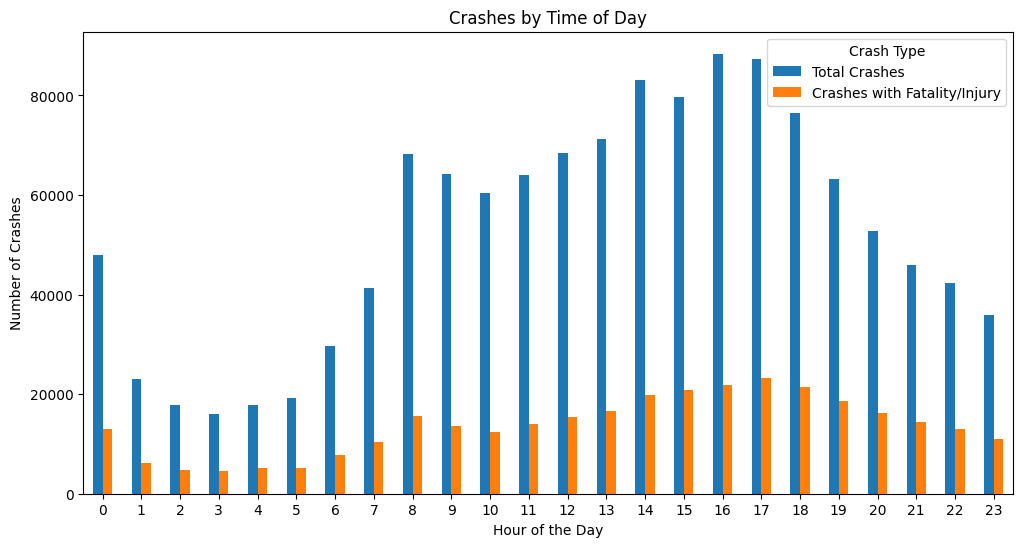

In [23]:

# Count total crashes per hour
hour_counts = df['CRASH HOUR'].value_counts().sort_index()

# Count crashes with fatalities or injuries per hour
fatal_injury_hour_counts = df[df['HAS_FATALITY_OR_INJURY'] == 1]['CRASH HOUR'].value_counts().sort_index()

# Combine the data into a DataFrame for easier plotting
hourly_counts_df = pd.DataFrame({
    'Total Crashes': hour_counts,
    'Crashes with Fatality/Injury': fatal_injury_hour_counts
}).fillna(0)

# Plot
plt.figure(figsize=(12, 6))
hourly_counts_df.plot(kind='bar', ax=plt.gca())
plt.title('Crashes by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=0)
plt.legend(title='Crash Type')
plt.show()

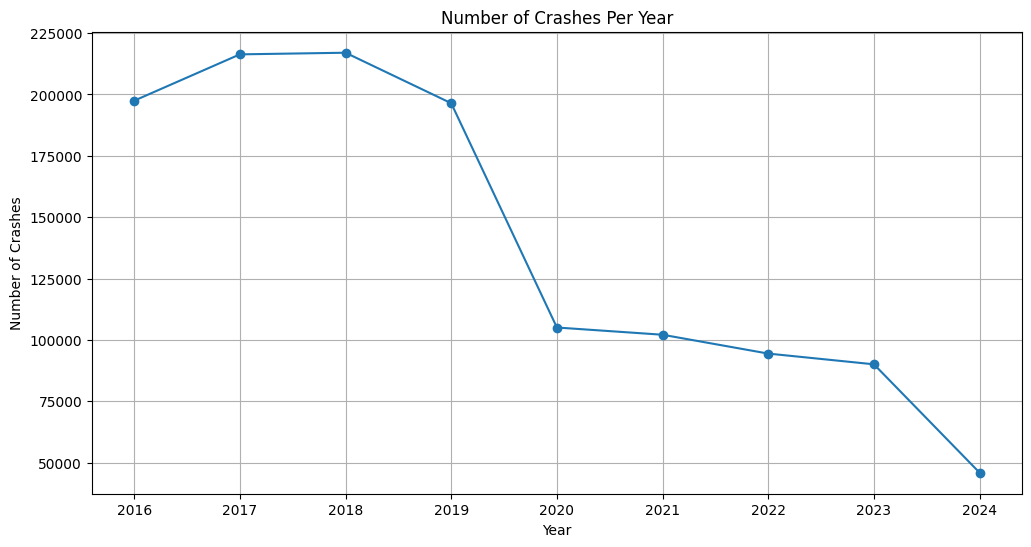

In [24]:
# Convert CRASH DATE to datetime format
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Group by year and count the number of crashes
crashes_per_year = df.groupby(df['CRASH DATE'].dt.year).size()

# Plot
plt.figure(figsize=(12, 6))
crashes_per_year.plot(kind='line', marker='o')
plt.title('Number of Crashes Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.grid(True)
plt.show()

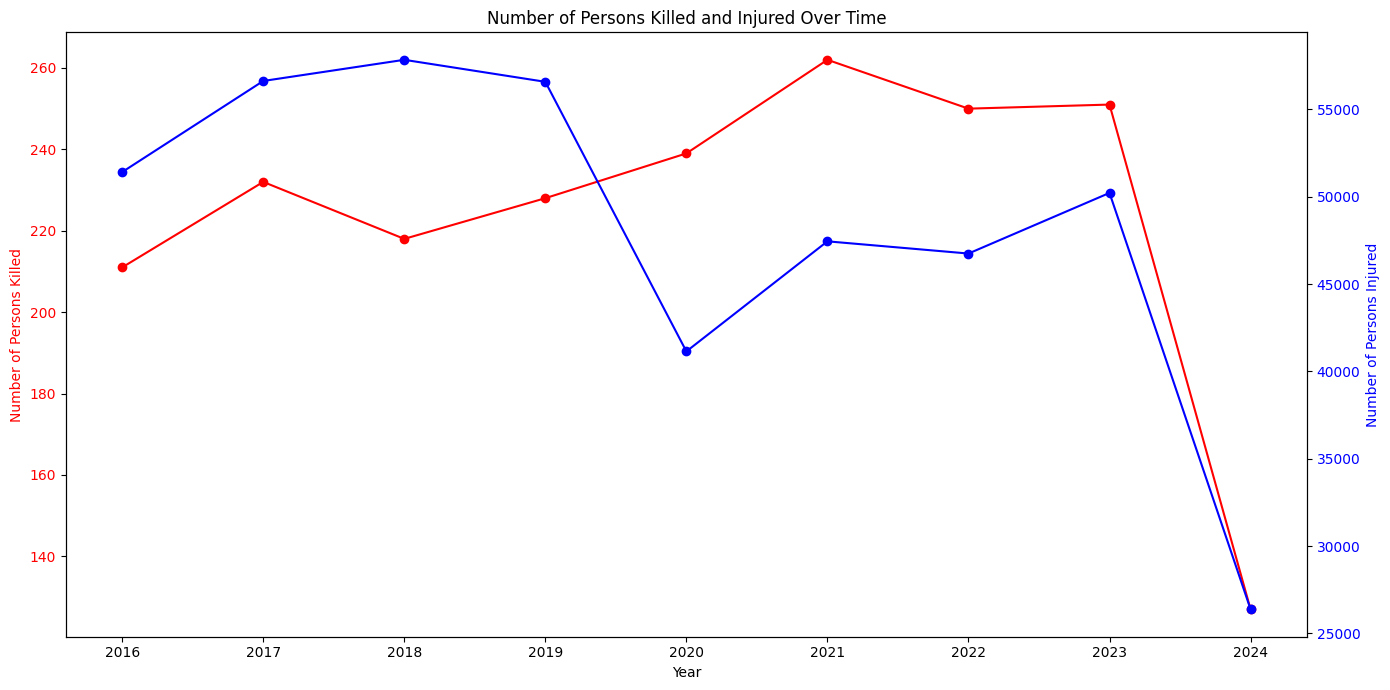

In [25]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Group by year and sum the number of persons killed and injured
annual_stats = df.groupby(df['CRASH DATE'].dt.year).agg({
    'NUMBER OF PERSONS KILLED': 'sum',
    'NUMBER OF PERSONS INJURED': 'sum'
}).reset_index()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot number of persons killed
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Persons Killed', color='red')
ax1.plot(annual_stats['CRASH DATE'], annual_stats['NUMBER OF PERSONS KILLED'], marker='o', color='red', label='Number of Persons Killed')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for number of persons injured
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Persons Injured', color='blue')
ax2.plot(annual_stats['CRASH DATE'], annual_stats['NUMBER OF PERSONS INJURED'], marker='o', color='blue', label='Number of Persons Injured')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Number of Persons Killed and Injured Over Time')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

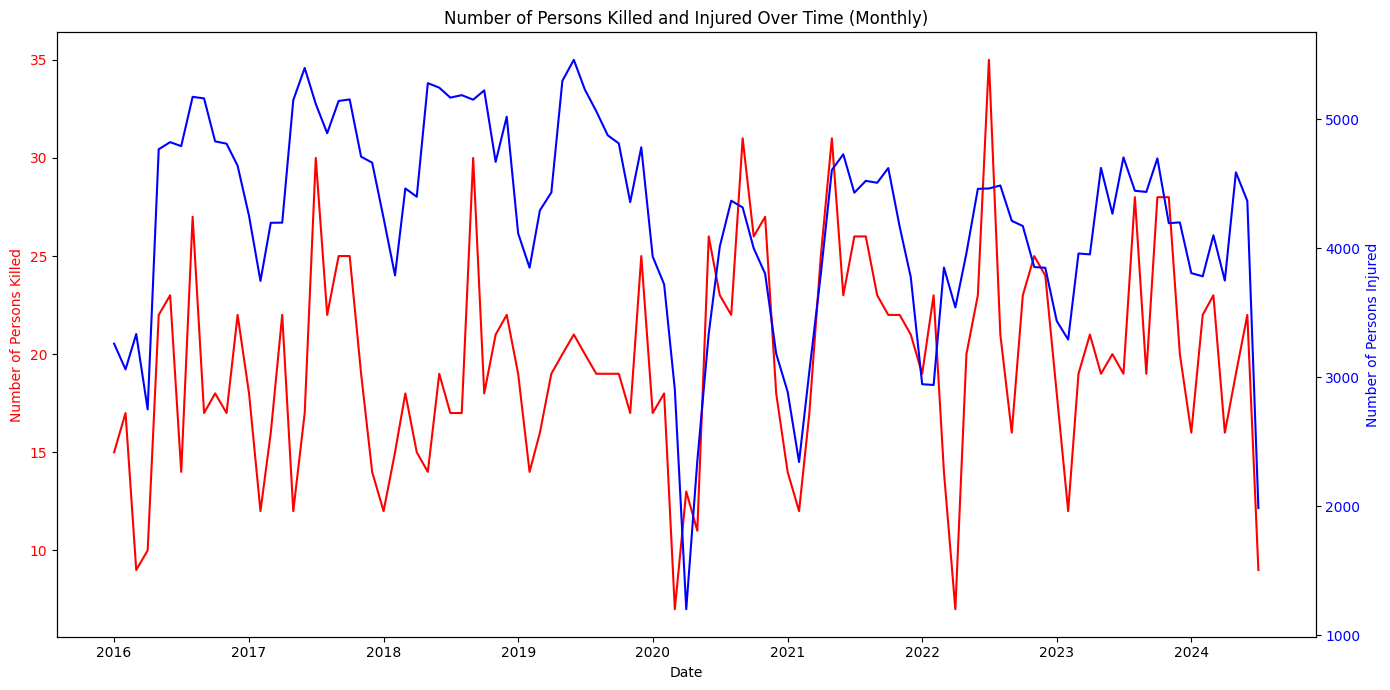

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'CRASH DATE' to datetime if not already
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Group by month and sum the number of persons killed and injured
monthly_stats = df.groupby(df['CRASH DATE'].dt.to_period('M')).agg({
    'NUMBER OF PERSONS KILLED': 'sum',
    'NUMBER OF PERSONS INJURED': 'sum'
}).reset_index()

# Convert back to a datetime object for plotting
monthly_stats['CRASH DATE'] = monthly_stats['CRASH DATE'].dt.to_timestamp()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot number of persons killed
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Persons Killed', color='red')
ax1.plot(monthly_stats['CRASH DATE'], monthly_stats['NUMBER OF PERSONS KILLED'], color='red', label='Number of Persons Killed')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for number of persons injured
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Persons Injured', color='blue')
ax2.plot(monthly_stats['CRASH DATE'], monthly_stats['NUMBER OF PERSONS INJURED'], color='blue', label='Number of Persons Injured')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Number of Persons Killed and Injured Over Time (Monthly)')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

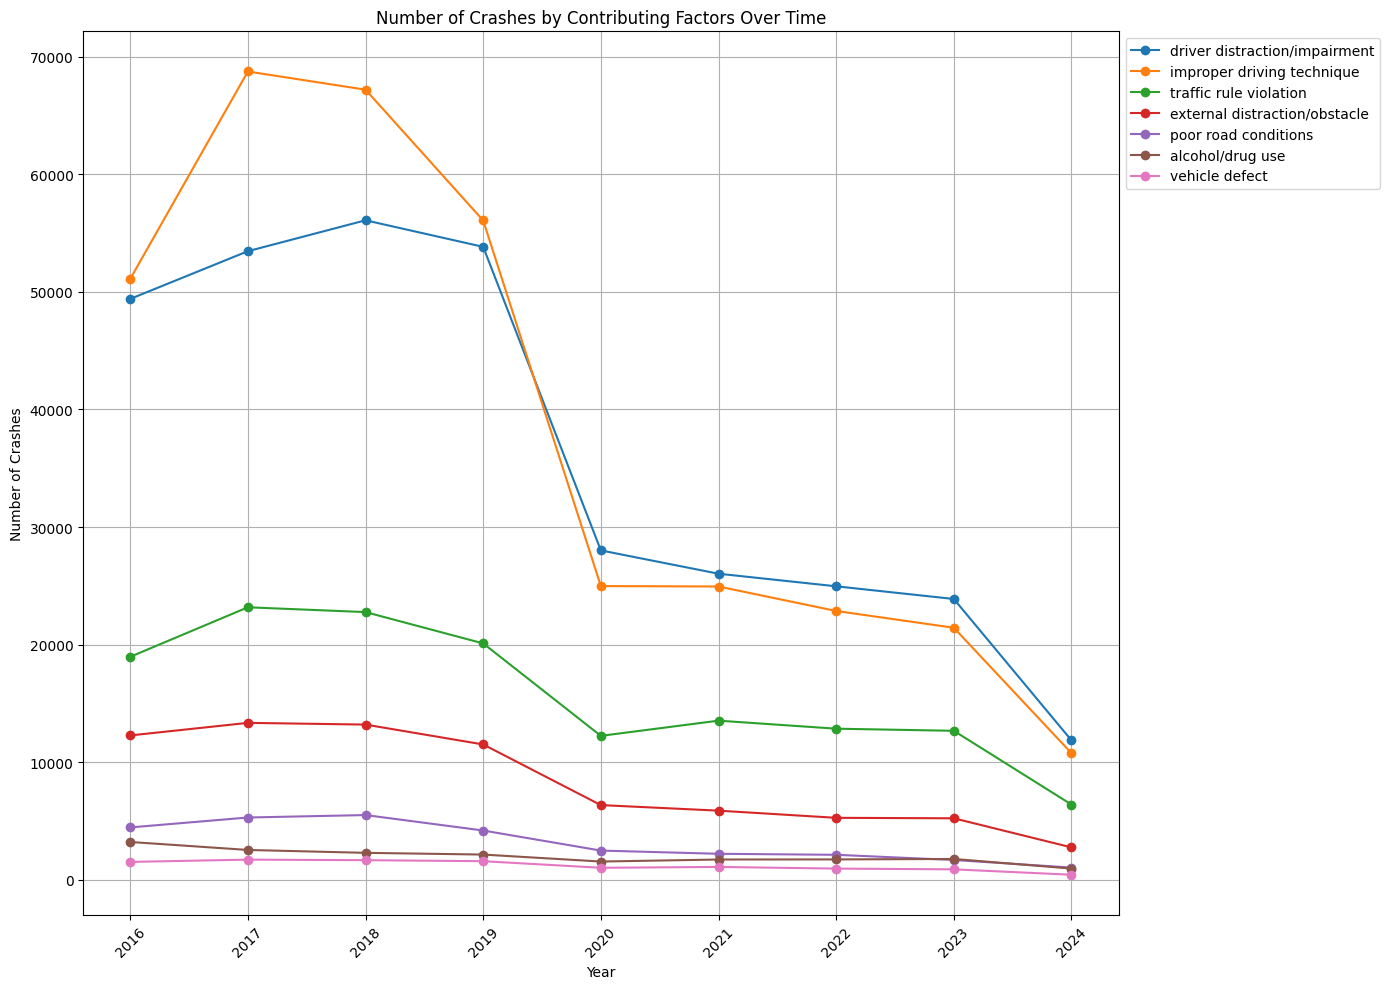

In [27]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

# Count number of crashes by year and contributing factor
annual_factors = df.groupby([df['CRASH DATE'].dt.year, 'CONTRIBUTING FACTOR VEHICLE 1']).size().reset_index(name='NUMBER OF CRASHES')

# List of contributing factors to loop through
contributing_factors = [
    'driver distraction/impairment',
    'improper driving technique',
    'traffic rule violation',
    'external distraction/obstacle',
    'poor road conditions',
    'alcohol/drug use',
    'vehicle defect'
]

plt.figure(figsize=(14, 10))

for factor in contributing_factors:
    factor_data = annual_factors[annual_factors['CONTRIBUTING FACTOR VEHICLE 1'] == factor]
    
    plt.plot(factor_data['CRASH DATE'], factor_data['NUMBER OF CRASHES'], marker='o', label=f'{factor}')

plt.xlabel('Year')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes by Contributing Factors Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

Unfortunately there isn't really a correlation between the contributing factors and injury/fatalaties. So it will likely not be beneficial with severity as a target.

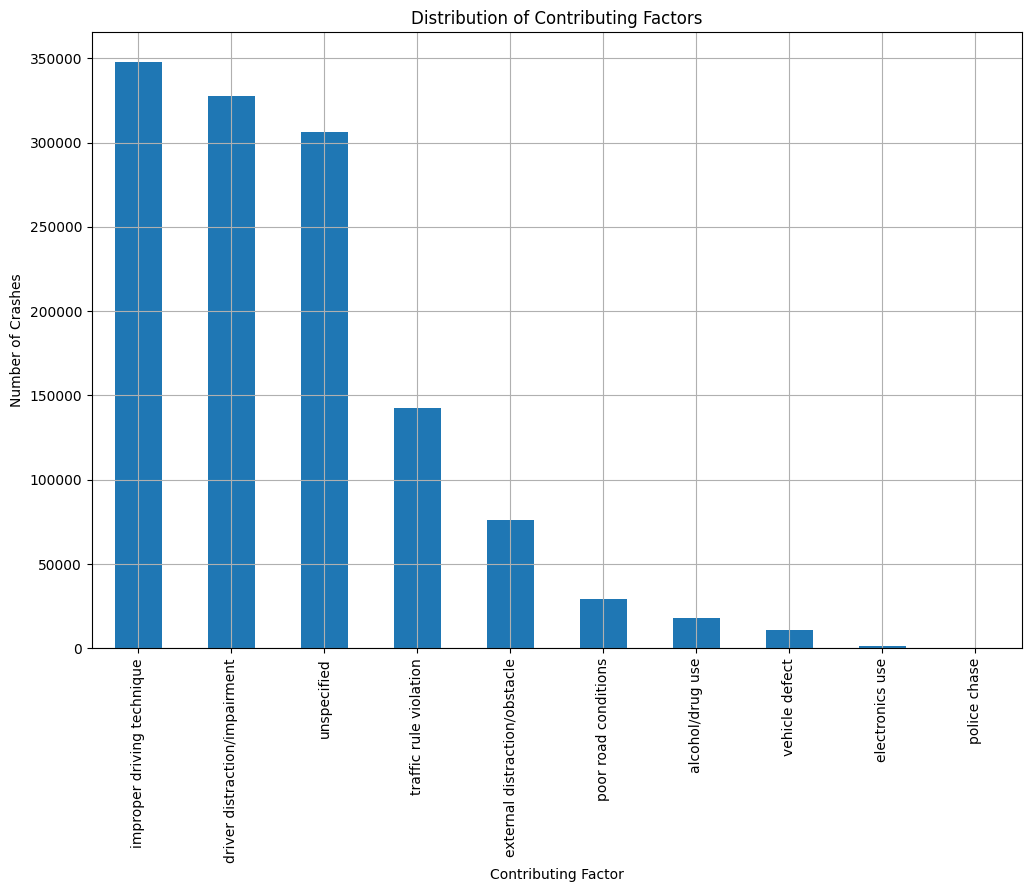

In [28]:

# Count crash types
crash_type_counts = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

# Plot
plt.figure(figsize=(12, 8))
crash_type_counts.plot(kind='bar')
plt.title('Distribution of Contributing Factors')
plt.xlabel('Contributing Factor')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# K Means Clustering

## NYC

No matter how few or many clusters I make, using NYC as a whole, I end up with clusters that extend over waterways which isn't idea. Therefor I applied the K-Means Clustering to the each borough seperately with far better results.

## Manhattan

C:\Users\dougl\AppData\Local\Temp\ipykernel_6256\719766486.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_subset['Cluster'] = kmeans.labels_


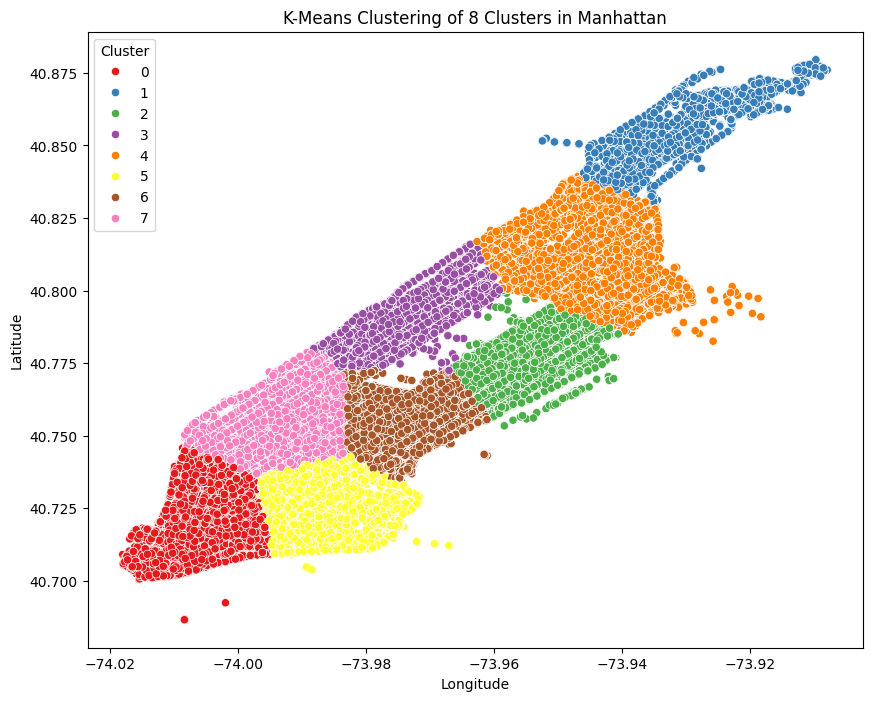

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



#Filter DataFrame for the suburb 'Manhattan'
manhattan_subset = df[df['BOROUGH'] == 'Manhattan']
coordinates = manhattan_subset[['LONGITUDE', 'LATITUDE']].dropna()

#Scale the coordinates
scaler = StandardScaler()
coordinates_scaled = scaler.fit_transform(coordinates)

# Perform K-means clustering
n_clusters = 8  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(coordinates_scaled)

# Add the cluster labels to the subset DataFrame
manhattan_subset['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='LONGITUDE', 
    y='LATITUDE', 
    hue='Cluster', 
    palette='Set1', 
    data=manhattan_subset, 
    marker='o', 
    edgecolor='w'
)
plt.title(f'K-Means Clustering of {n_clusters} Clusters in Manhattan')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.show()

C:\Users\dougl\AppData\Local\Temp\ipykernel_6256\1313098550.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borough_data['CLUSTER'] = kmeans.fit_predict(scaled_coordinates)
C:\Users\dougl\AppData\Local\Temp\ipykernel_6256\1313098550.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borough_data['CLUSTER NAME'] = borough_data.apply(lambda row: f"{borough}_{row['CLUSTER']}", axis=1)
C:\Users\dougl\AppData\Local\Temp\ipykernel_6256\1313098550.py:39: SettingWithCopyWarning: 
A value is trying to be set 

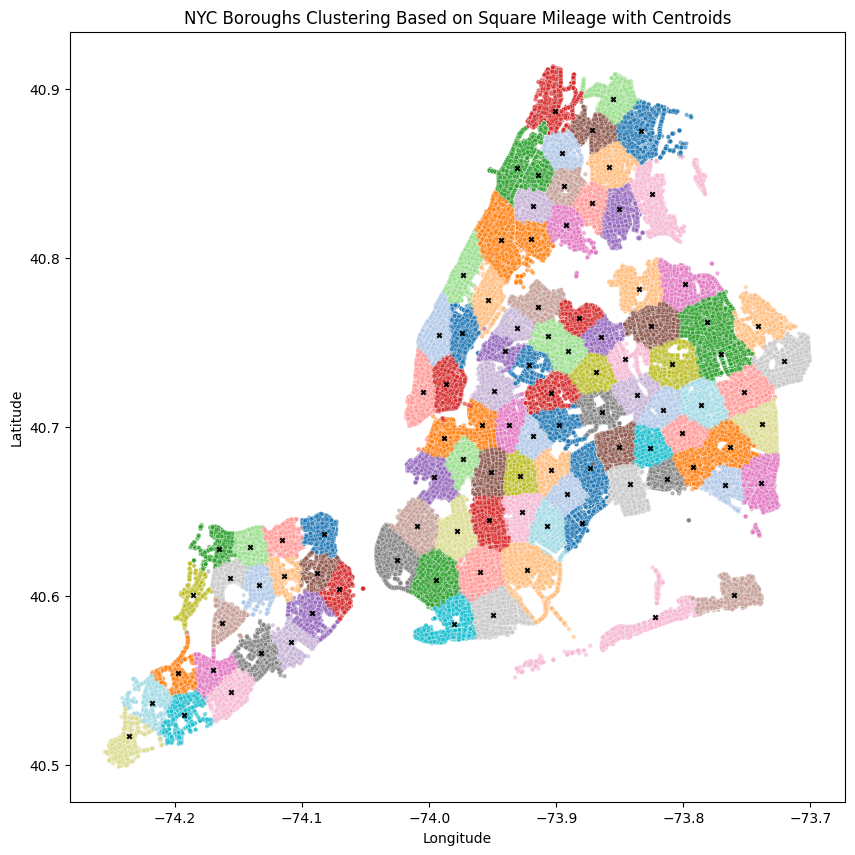

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the square mileage for each borough
borough_areas = {
    'The Bronx': 42,
    'Brooklyn': 71,
    'Manhattan': 23,
    'Queens': 109,
    'Staten Island': 59
}

# Base clusters for Manhattan
min_clusters = 8

# Calculate clusters for each borough
borough_k = {borough: int((area / borough_areas['Manhattan']) * min_clusters) 
             for borough, area in borough_areas.items()}

# List to store clustered dataframes
dfs = []

# Map to store centroids
centroid_map = {}

# Perform clustering for each borough
for borough, k in borough_k.items():
    borough_data = df[df['BOROUGH'] == borough]
    
    # Scaling the coordinates
    scaler = StandardScaler()
    scaled_coordinates = scaler.fit_transform(borough_data[['LATITUDE', 'LONGITUDE']])
    
    # Perform clustering on the scaled coordinates
    kmeans = KMeans(n_clusters=k, random_state=0)
    borough_data['CLUSTER'] = kmeans.fit_predict(scaled_coordinates)
    
    # Create unique cluster names combining borough and cluster number
    borough_data['CLUSTER NAME'] = borough_data.apply(lambda row: f"{borough}_{row['CLUSTER']}", axis=1)
    
    # Store the centroids in the dictionary using CLUSTER NAME
    for i, center in enumerate(kmeans.cluster_centers_):
        # Transform centroids back to the original scale
        original_center = scaler.inverse_transform([center])[0]
        cluster_name = f"{borough}_{i}"
        centroid_map[cluster_name] = original_center
    
    # Append the clustered borough data to the list
    dfs.append(borough_data)

# Merge all boroughs back together
df_clustered = pd.concat(dfs)

# Set up the plot
plt.figure(figsize=(10, 10))

# Iterate through each borough and plot the clusters
for borough in df_clustered['BOROUGH'].unique():
    borough_data = df_clustered[df_clustered['BOROUGH'] == borough]
    latitudes = borough_data['LATITUDE'].values
    longitudes = borough_data['LONGITUDE'].values
    clusters = borough_data['CLUSTER NAME'].values

    # Plotting the clusters
    sns.scatterplot(x=longitudes, y=latitudes, hue=clusters, palette="tab20", s=10, alpha=0.6, legend=False)

# Plot the centroids
for cluster_name, centroid in centroid_map.items():
    # Extract the coordinates of the centroid
    lat, lon = centroid[0], centroid[1]
    plt.scatter(lon, lat, c='black', s=10, marker='x', label=f"{cluster_name} Centroid")

plt.title("NYC Boroughs Clustering Based on Square Mileage with Centroids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Lets Check Out Our Centeroids!

In [31]:
# Print the contents of centroid_map
for cluster_name, centroid in centroid_map.items():
    print(f"Cluster Name: {cluster_name}, Centroid Coordinates: {centroid}")

Cluster Name: The Bronx_0, Centroid Coordinates: [ 40.84893652 -73.91443009]
Cluster Name: The Bronx_1, Centroid Coordinates: [ 40.82858901 -73.85042974]
Cluster Name: The Bronx_2, Centroid Coordinates: [ 40.89351894 -73.85562135]
Cluster Name: The Bronx_3, Centroid Coordinates: [ 40.81102786 -73.91969088]
Cluster Name: The Bronx_4, Centroid Coordinates: [ 40.819183   -73.89215307]
Cluster Name: The Bronx_5, Centroid Coordinates: [ 40.85332371 -73.85837979]
Cluster Name: The Bronx_6, Centroid Coordinates: [ 40.87543302 -73.87162057]
Cluster Name: The Bronx_7, Centroid Coordinates: [ 40.86183526 -73.89580611]
Cluster Name: The Bronx_8, Centroid Coordinates: [ 40.8376461  -73.82489902]
Cluster Name: The Bronx_9, Centroid Coordinates: [ 40.83245159 -73.87159462]
Cluster Name: The Bronx_10, Centroid Coordinates: [ 40.83062592 -73.91868141]
Cluster Name: The Bronx_11, Centroid Coordinates: [ 40.84248782 -73.89384781]
Cluster Name: The Bronx_12, Centroid Coordinates: [ 40.87508439 -73.833314

# Lets Check Out Some Clusters Now!

In [32]:
df_clustered['CLUSTER NAME'].value_counts()

CLUSTER NAME
Manhattan_4         44321
Manhattan_7         39764
Manhattan_6         37020
Manhattan_0         31249
Manhattan_5         28603
Manhattan_2         24947
Brooklyn_16         22444
Brooklyn_17         21083
Brooklyn_6          20256
Brooklyn_9          20099
Manhattan_1         20066
Brooklyn_2          19706
Brooklyn_22         19517
The Bronx_3         19477
The Bronx_7         18804
Brooklyn_3          18434
The Bronx_0         18231
Queens_5            18214
Brooklyn_19         18169
Brooklyn_13         17560
Brooklyn_23         16883
The Bronx_4         16805
The Bronx_10        16758
Brooklyn_18         16713
Brooklyn_0          16669
Brooklyn_12         16662
The Bronx_9         16519
Brooklyn_11         16004
Manhattan_3         15917
Brooklyn_10         15275
Brooklyn_15         15189
Brooklyn_8          14869
The Bronx_11        14843
Brooklyn_1          14827
The Bronx_6         14478
Brooklyn_7          13923
Brooklyn_4          13829
Brooklyn_14         13148

In [33]:
# Assume df is your dataframe
# Step 1: Group by 'CLUSTER NAME' and aggregate
cluster_aggregates = df.groupby('CLUSTER NAME').agg({
    'NUMBER OF PERSONS KILLED': 'sum',
    'NUMBER OF PERSONS INJURED': 'sum',
    'NUMBER OF PEDESTRIANS KILLED': 'sum',
    'NUMBER OF PEDESTRIANS INJURED': 'sum',
    'HAS_FATALITY_OR_INJURY' : 'sum',
}).reset_index()

# Step 2: Sort and rank by 'NUMBER OF PERSONS KILLED'
cluster_aggregates['KILLED_RANK'] = cluster_aggregates['NUMBER OF PERSONS KILLED'].rank(ascending=False)

# Step 3: Sort and rank by 'NUMBER OF PERSONS INJURED'
cluster_aggregates['INJURED_RANK'] = cluster_aggregates['NUMBER OF PERSONS INJURED'].rank(ascending=False)

# Step 4: Sort and rank by 'NUMBER OF PERSONS KILLED'
cluster_aggregates['KILLED_PED_RANK'] = cluster_aggregates['NUMBER OF PEDESTRIANS KILLED'].rank(ascending=False)

# Step 5: Sort and rank by 'NUMBER OF PERSONS INJURED'
cluster_aggregates['INJURED_PED_RANK'] = cluster_aggregates['NUMBER OF PEDESTRIANS INJURED'].rank(ascending=False)
# Step 5: Sort and rank by 'NUMBER OF PERSONS INJURED'
cluster_aggregates['FAT/INJ RANK'] = cluster_aggregates['HAS_FATALITY_OR_INJURY'].rank(ascending=False)

# Step 4: Map the rankings back to the original dataframe
df = df.merge(cluster_aggregates[['CLUSTER NAME', 'KILLED_RANK', 'INJURED_RANK', 'KILLED_PED_RANK', 'INJURED_PED_RANK','FAT/INJ RANK' ]], on='CLUSTER NAME', how='left')

# Now df contains the ranking columns based on the sorted aggregates


In [34]:
# Filter dataframe for each contributing factor
df_improper_driving = df[(df['CONTRIBUTING FACTOR VEHICLE 1'] == 'improper driving technique') | 
                         (df['CONTRIBUTING FACTOR VEHICLE 2'] == 'improper driving technique')]

df_alcohol_drug = df[(df['CONTRIBUTING FACTOR VEHICLE 1'] == 'alcohol/drug use') | 
                     (df['CONTRIBUTING FACTOR VEHICLE 2'] == 'alcohol/drug use')]

df_poor_road_conditions = df[(df['CONTRIBUTING FACTOR VEHICLE 1'] == 'poor road conditions') | 
                             (df['CONTRIBUTING FACTOR VEHICLE 2'] == 'poor road conditions')]

# Aggregate by 'CLUSTER NAME'
improper_driving_counts = df_improper_driving.groupby('CLUSTER NAME').size().reset_index(name='IMPROPER_DRIVING_COUNT')
alcohol_drug_counts = df_alcohol_drug.groupby('CLUSTER NAME').size().reset_index(name='ALCOHOL_DRUG_COUNT')
poor_road_conditions_counts = df_poor_road_conditions.groupby('CLUSTER NAME').size().reset_index(name='POOR_ROAD_CONDITIONS_COUNT')

# Rank the clusters
improper_driving_counts['IMPROPER_DRIVING_RANK'] = improper_driving_counts['IMPROPER_DRIVING_COUNT'].rank(ascending=False)
alcohol_drug_counts['ALCOHOL_DRUG_RANK'] = alcohol_drug_counts['ALCOHOL_DRUG_COUNT'].rank(ascending=False)
poor_road_conditions_counts['POOR_ROAD_CONDITIONS_RANK'] = poor_road_conditions_counts['POOR_ROAD_CONDITIONS_COUNT'].rank(ascending=False)

# Merge ranks into the original dataframe
df = df.merge(improper_driving_counts[['CLUSTER NAME', 'IMPROPER_DRIVING_RANK']], on='CLUSTER NAME', how='left')
df = df.merge(alcohol_drug_counts[['CLUSTER NAME', 'ALCOHOL_DRUG_RANK']], on='CLUSTER NAME', how='left')
df = df.merge(poor_road_conditions_counts[['CLUSTER NAME', 'POOR_ROAD_CONDITIONS_RANK']], on='CLUSTER NAME', how='left')

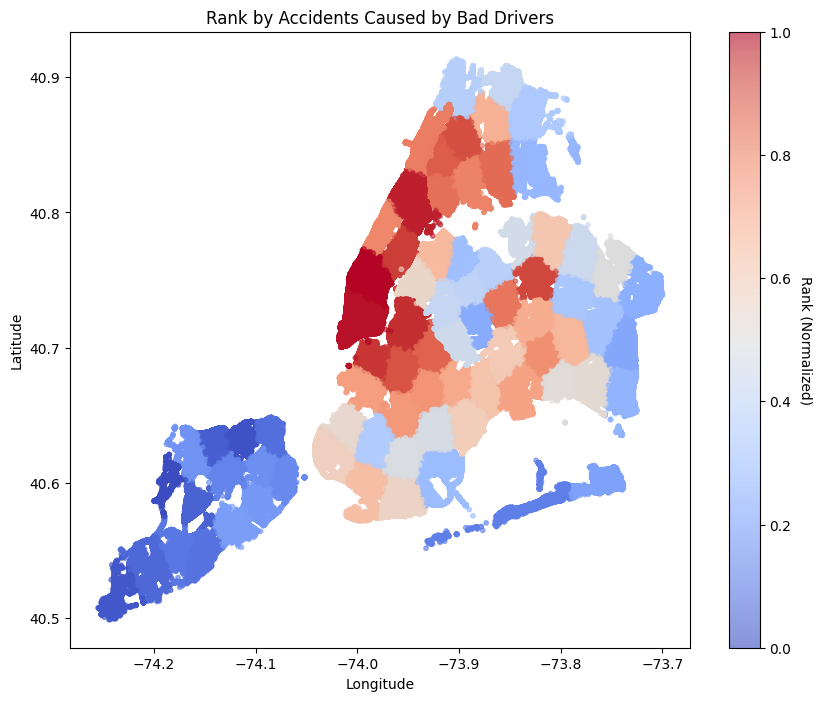

In [35]:
# Reverse the normalization to invert the color mapping
df['IMPROPER_DRIVING_RANK_NORMALIZED'] = 1 - ((df['IMPROPER_DRIVING_RANK'] - df['IMPROPER_DRIVING_RANK'].min()) / (df['IMPROPER_DRIVING_RANK'].max() - df['IMPROPER_DRIVING_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['IMPROPER_DRIVING_RANK_NORMALIZED'], cmap=cmap, 
            s=10, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rank by Accidents Caused by Bad Drivers')

# Display the plot
plt.show()

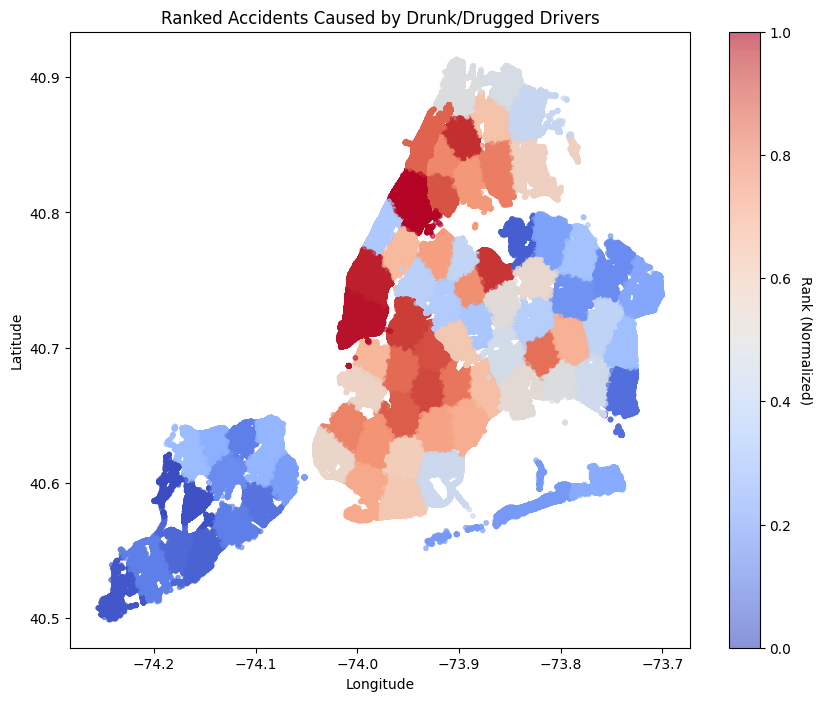

In [36]:
# Reverse the normalization to invert the color mapping
df['ALCOHOL_DRUG_RANK_NORMALIZED'] = 1 - ((df['ALCOHOL_DRUG_RANK'] - df['ALCOHOL_DRUG_RANK'].min()) / (df['ALCOHOL_DRUG_RANK'].max() - df['ALCOHOL_DRUG_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['ALCOHOL_DRUG_RANK_NORMALIZED'], cmap=cmap, 
            s=10, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ranked Accidents Caused by Drunk/Drugged Drivers')

# Display the plot
plt.show()

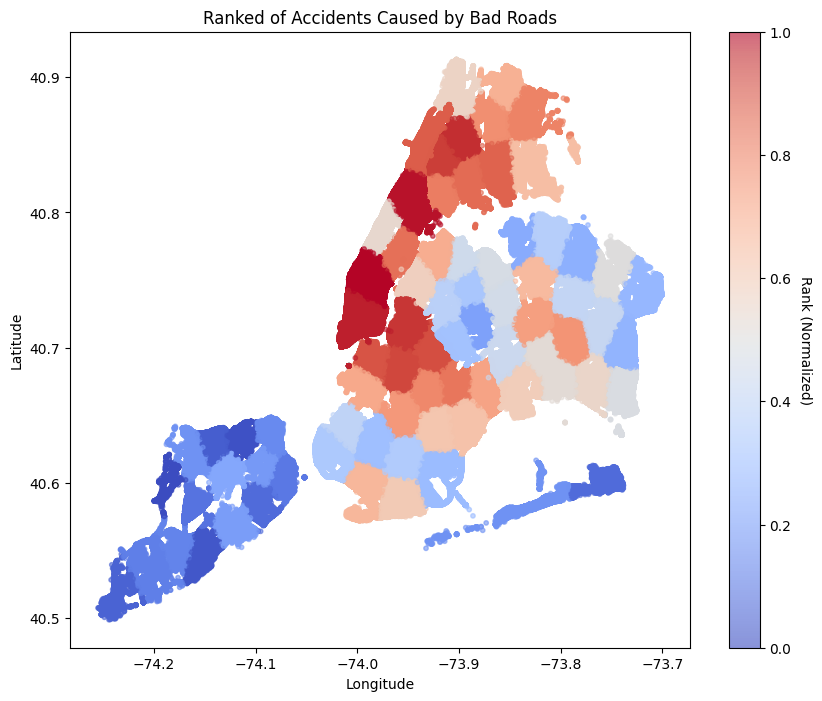

In [37]:

# Reverse the normalization to invert the color mapping
df['POOR_ROAD_CONDITIONS_RANK_NORMALIZED'] = 1 - ((df['POOR_ROAD_CONDITIONS_RANK'] - df['POOR_ROAD_CONDITIONS_RANK'].min()) / (df['POOR_ROAD_CONDITIONS_RANK'].max() - df['POOR_ROAD_CONDITIONS_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['POOR_ROAD_CONDITIONS_RANK_NORMALIZED'], cmap=cmap, 
            s=10, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ranked of Accidents Caused by Bad Roads')

# Display the plot
plt.show()

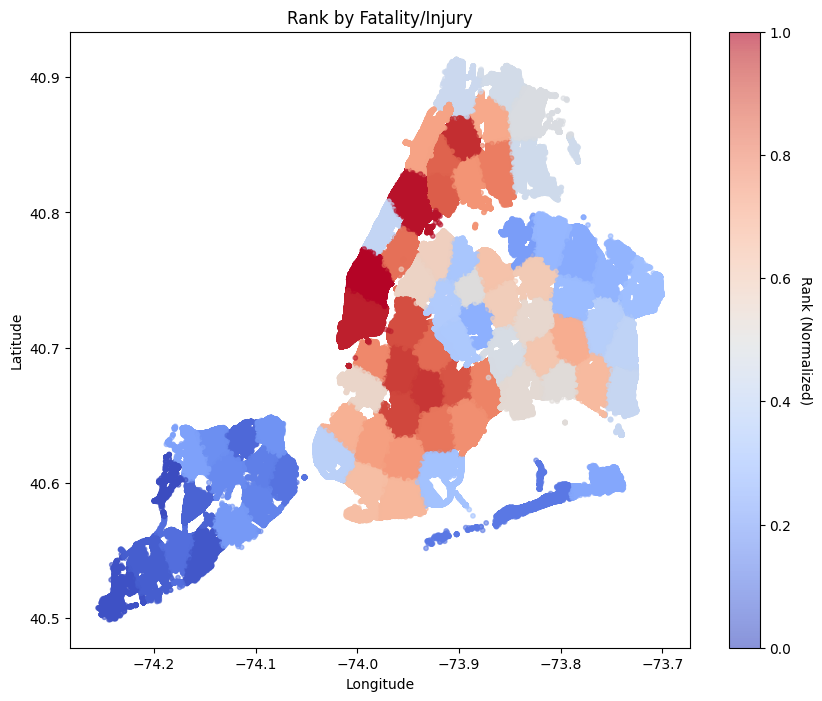

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Reverse the normalization to invert the color mapping
df['FATALITY_INJURY_RANK_NORMALIZED'] = 1 - ((df['FAT/INJ RANK'] - df['FAT/INJ RANK'].min()) / (df['FAT/INJ RANK'].max() - df['FAT/INJ RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['FATALITY_INJURY_RANK_NORMALIZED'], cmap=cmap, 
            s=10, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rank by Fatality/Injury')

# Display the plot
plt.show()

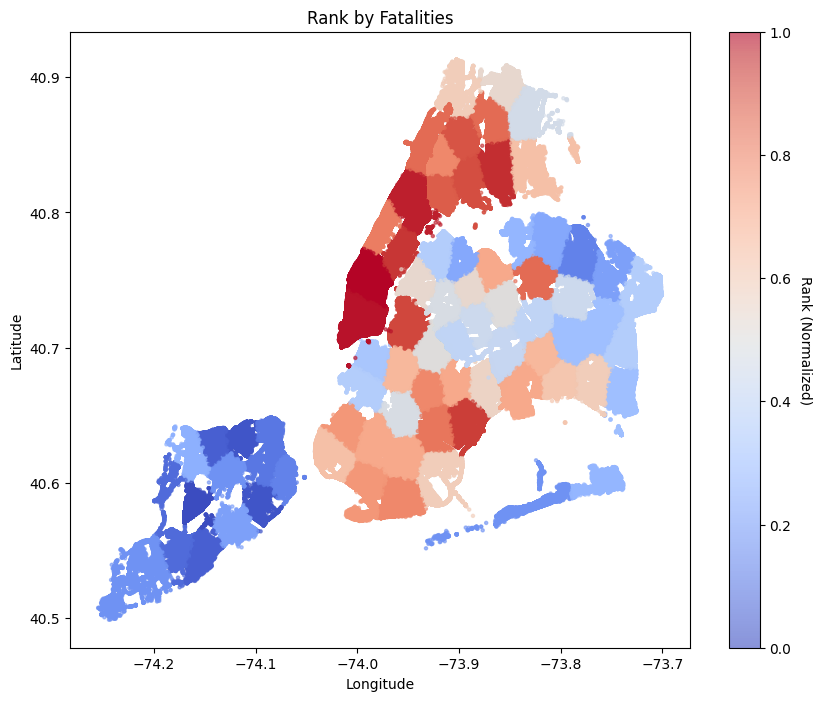

In [39]:
# Reverse the normalization to invert the color mapping
df['KILLED_RANK_NORMALIZED'] = 1 - ((df['KILLED_RANK'] - df['KILLED_RANK'].min()) / (df['KILLED_RANK'].max() - df['KILLED_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['KILLED_RANK_NORMALIZED'], cmap=cmap, 
            s=5, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rank by Fatalities')

# Display the plot
plt.show()

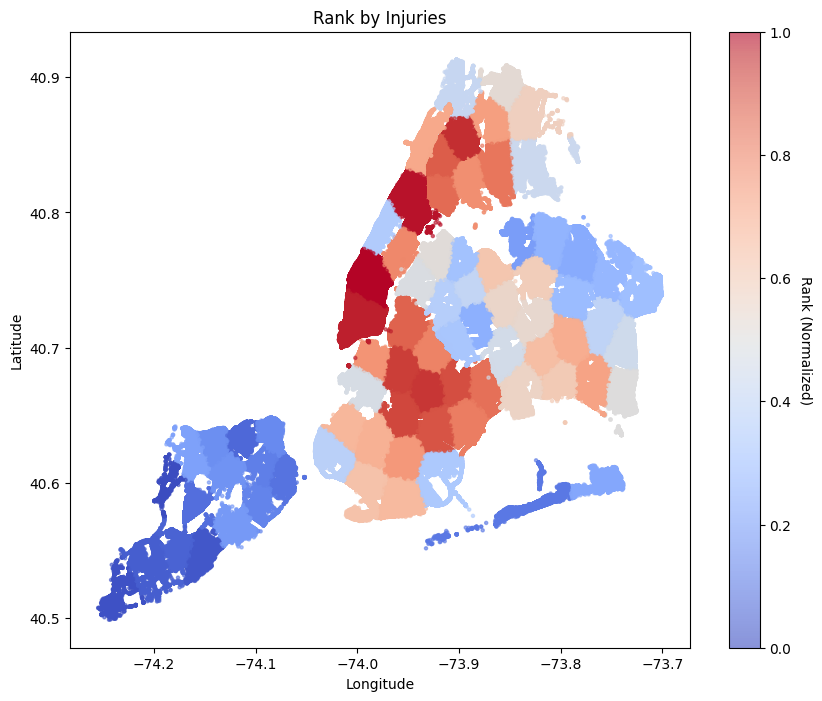

In [40]:
# Reverse the normalization to invert the color mapping
df['INJURED_RANK_NORMALIZED'] = 1 - ((df['INJURED_RANK'] - df['INJURED_RANK'].min()) / (df['INJURED_RANK'].max() - df['INJURED_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['INJURED_RANK_NORMALIZED'], cmap=cmap, 
            s=5, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rank by Injuries')

# Display the plot
plt.show()

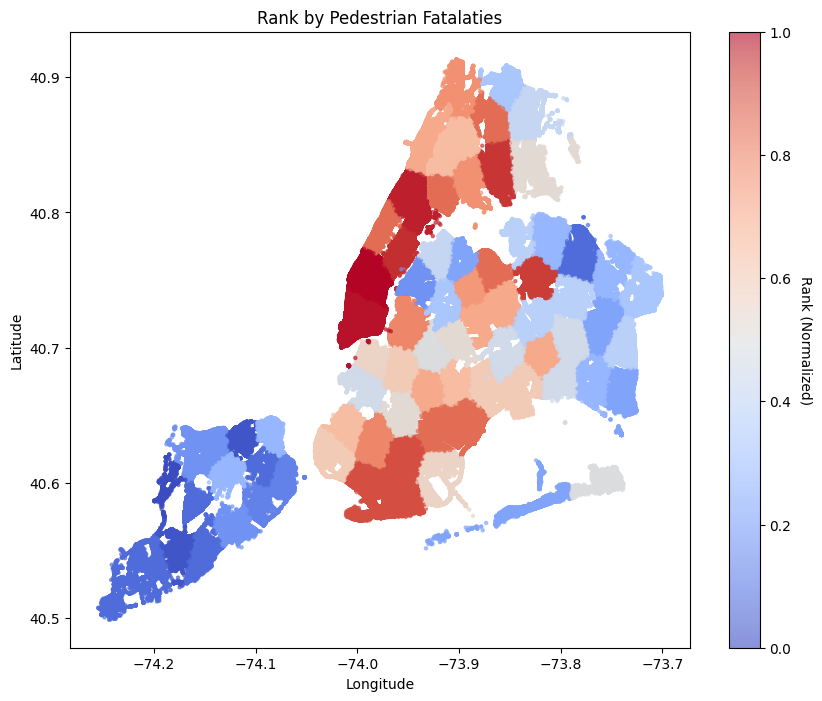

In [41]:
# Reverse the normalization to invert the color mapping
df['KILLED_PED_RANK_NORMALIZED'] = 1 - ((df['KILLED_PED_RANK'] - df['KILLED_PED_RANK'].min()) / (df['KILLED_PED_RANK'].max() - df['KILLED_PED_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['KILLED_PED_RANK_NORMALIZED'], cmap=cmap, 
            s=5, edgecolor= None , alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rank by Pedestrian Fatalaties')

# Display the plot
plt.show()

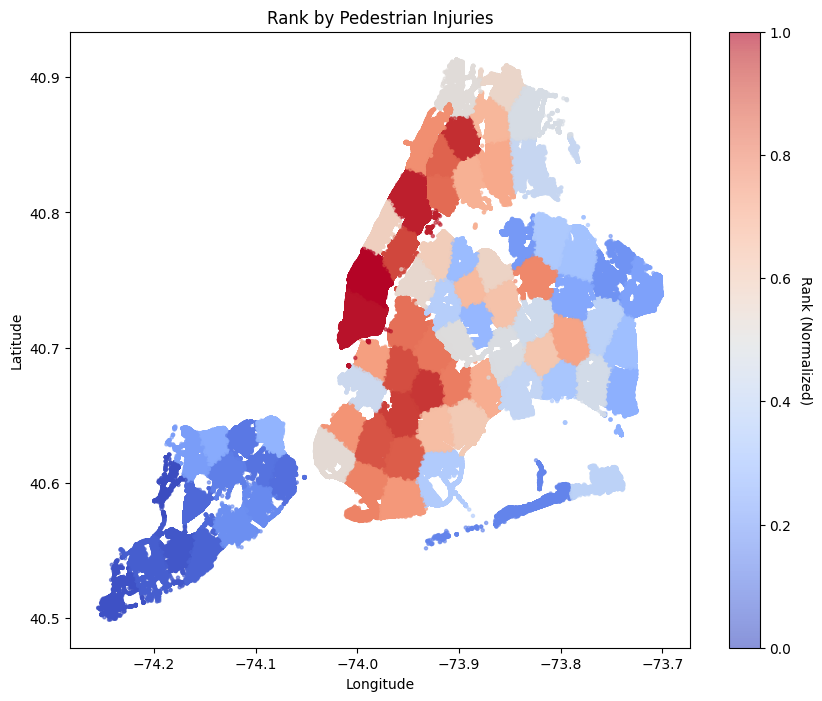

In [42]:
# Reverse the normalization to invert the color mapping
df['INJURED_PED_RANK_NORMALIZED'] = 1 - ((df['INJURED_PED_RANK'] - df['INJURED_PED_RANK'].min()) / (df['INJURED_PED_RANK'].max() - df['INJURED_PED_RANK'].min()))


# Step 2: Create a color map that goes from red (low rank) to blue (high rank)
cmap = plt.get_cmap('coolwarm') 

# Step 3: Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(df['LONGITUDE'], df['LATITUDE'], 
            c=df['INJURED_PED_RANK_NORMALIZED'], cmap=cmap, 
            s=5, edgecolor=None, alpha=0.6)

# Add a color bar to the plot
cbar = plt.colorbar()
cbar.set_label('Rank (Normalized)', rotation=270, labelpad=15)

# Set the labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Rank by Pedestrian Injuries')

# Display the plot
plt.show()

In [43]:
# Group by cluster and sum the number of persons killed and injured
stats = df_clustered.groupby('CLUSTER NAME').agg({
    'NUMBER OF PERSONS KILLED': 'sum',
    'NUMBER OF PERSONS INJURED': 'sum',
    'NUMBER OF PEDESTRIANS KILLED': 'sum',
    'NUMBER OF PEDESTRIANS INJURED': 'sum',
}).reset_index()

# Display the result
print(stats)



         CLUSTER NAME  NUMBER OF PERSONS KILLED  NUMBER OF PERSONS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF PEDESTRIANS INJURED
0          Brooklyn_0                      21.0                     6703.0                            10                           1052
1          Brooklyn_1                      28.0                     5146.0                            15                           1342
2         Brooklyn_10                      32.0                     5290.0                            21                           1102
3         Brooklyn_11                      23.0                     7812.0                            11                           1039
4         Brooklyn_12                      10.0                     5498.0                             7                           1028
5         Brooklyn_13                      34.0                     5696.0                            26                           1462
6         Brooklyn_14                      29.0 

In [44]:
# Sort the clusters by the number of persons killed in descending order
rank_killed = stats.sort_values(by='NUMBER OF PERSONS KILLED', ascending=False)

# Display the sorted result
print(rank_killed)

         CLUSTER NAME  NUMBER OF PERSONS KILLED  NUMBER OF PERSONS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF PEDESTRIANS INJURED
28        Manhattan_4                      61.0                    15168.0                            36                           3100
31        Manhattan_7                      53.0                     8326.0                            36                           2830
26        Manhattan_2                      46.0                     6183.0                            32                           1456
29        Manhattan_5                      41.0                     8806.0                            31                           2183
102       The Bronx_9                      41.0                     5880.0                            20                            896
97        The Bronx_4                      40.0                     5984.0                            14                            923
64           Queens_5                      38.0 

In [45]:
# Sort the clusters by the number of persons injured in descending order
rank_injured = stats.sort_values(by='NUMBER OF PERSONS INJURED', ascending=False)

# Display the sorted result
print(rank_injured)

         CLUSTER NAME  NUMBER OF PERSONS KILLED  NUMBER OF PERSONS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF PEDESTRIANS INJURED
28        Manhattan_4                      61.0                    15168.0                            36                           3100
8         Brooklyn_16                      20.0                     9809.0                            10                           1987
9         Brooklyn_17                      30.0                     9140.0                            14                           1769
30        Manhattan_6                      36.0                     9074.0                            21                           2438
29        Manhattan_5                      41.0                     8806.0                            31                           2183
31        Manhattan_7                      53.0                     8326.0                            36                           2830
12         Brooklyn_2                      19.0 

In [46]:
# Sort the clusters by the number of persons injured in descending order
rank_ped_killed = stats.sort_values(by='NUMBER OF PEDESTRIANS KILLED', ascending=False)

# Display the sorted result
print(rank_ped_killed)

         CLUSTER NAME  NUMBER OF PERSONS KILLED  NUMBER OF PERSONS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF PEDESTRIANS INJURED
31        Manhattan_7                      53.0                     8326.0                            36                           2830
28        Manhattan_4                      61.0                    15168.0                            36                           3100
26        Manhattan_2                      46.0                     6183.0                            32                           1456
29        Manhattan_5                      41.0                     8806.0                            31                           2183
5         Brooklyn_13                      34.0                     5696.0                            26                           1462
64           Queens_5                      38.0                     5181.0                            25                           1622
2         Brooklyn_10                      32.0 

In [47]:
# Sort the clusters by the number of persons injured in descending order
rank_ped_injured = stats.sort_values(by='NUMBER OF PEDESTRIANS INJURED', ascending=False)

# Display the sorted result
print(rank_ped_injured)

         CLUSTER NAME  NUMBER OF PERSONS KILLED  NUMBER OF PERSONS INJURED  NUMBER OF PEDESTRIANS KILLED  NUMBER OF PEDESTRIANS INJURED
28        Manhattan_4                      61.0                    15168.0                            36                           3100
31        Manhattan_7                      53.0                     8326.0                            36                           2830
30        Manhattan_6                      36.0                     9074.0                            21                           2438
29        Manhattan_5                      41.0                     8806.0                            31                           2183
8         Brooklyn_16                      20.0                     9809.0                            10                           1987
24        Manhattan_0                      35.0                     6656.0                            21                           1856
9         Brooklyn_17                      30.0 

Manhattan_2 sounds pretty scary with 68569 accidents! Where as Staten Island_13 sounds like heaven with a measly 1359 accidents in the same time period. Less see whats going on the best, worst and a few other clusters.

In [48]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1264959 entries, 0 to 1264958
Columns: 123 entries, Unnamed: 0.1 to CLUSTER
dtypes: UInt32(1), bool(2), datetime64[ns](1), float64(17), int32(2), int64(35), object(65)
memory usage: 1.1+ GB


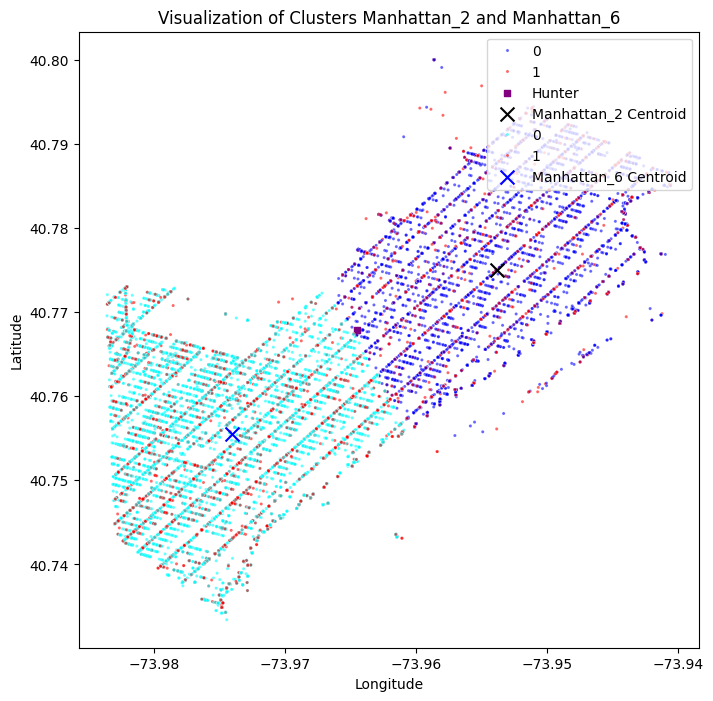

In [49]:
# Filter the dataframe for the 'Manhattan_4' cluster
cluster_data = df_clustered[df_clustered['CLUSTER NAME'] == 'Manhattan_2']
latitudes = cluster_data['LATITUDE'].values
longitudes = cluster_data['LONGITUDE'].values
fatality_or_injury = cluster_data['HAS_FATALITY_OR_INJURY'].values

# Get the centroid coordinates for 'Manhattan_4'
centroid_lat, centroid_lon = centroid_map.get('Manhattan_2', (None, None))

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the cluster points with colors based on HAS_FATALITY_OR_INJURY
sns.scatterplot(x=longitudes, y=latitudes, hue=fatality_or_injury, palette={False: 'blue', True: 'red'}, legend='full', s=5, alpha=0.6)

#coordinates for Hunter College
hunter_latitude = 40.7678
hunter_longitude = -73.9645
plt.scatter(hunter_longitude, hunter_latitude, c='purple', s=20, marker='s', label='Hunter')

# Plot the centroid
if centroid_lat is not None and centroid_lon is not None:
    plt.scatter(centroid_lon, centroid_lat, color='black', marker='x', s=100, label='Manhattan_2 Centroid')

cluster_data = df_clustered[df_clustered['CLUSTER NAME'] == 'Manhattan_6']
latitudes = cluster_data['LATITUDE'].values
longitudes = cluster_data['LONGITUDE'].values
fatality_or_injury = cluster_data['HAS_FATALITY_OR_INJURY'].values

# Get the centroid coordinates for 'Manhattan_4'
centroid_lat, centroid_lon = centroid_map.get('Manhattan_6', (None, None))

# Plot the cluster points with colors based on HAS_FATALITY_OR_INJURY
sns.scatterplot(x=longitudes, y=latitudes, hue=fatality_or_injury, palette={False: 'cyan', True: 'red'}, legend='full', s=5, alpha=0.6)

# Plot the centroid
if centroid_lat is not None and centroid_lon is not None:
    plt.scatter(centroid_lon, centroid_lat, color='Blue', marker='x', s=100, label='Manhattan_6 Centroid')


# Add title and labels
plt.title("Visualization of Clusters Manhattan_2 and Manhattan_6")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')

# Show the plot
plt.show()
    

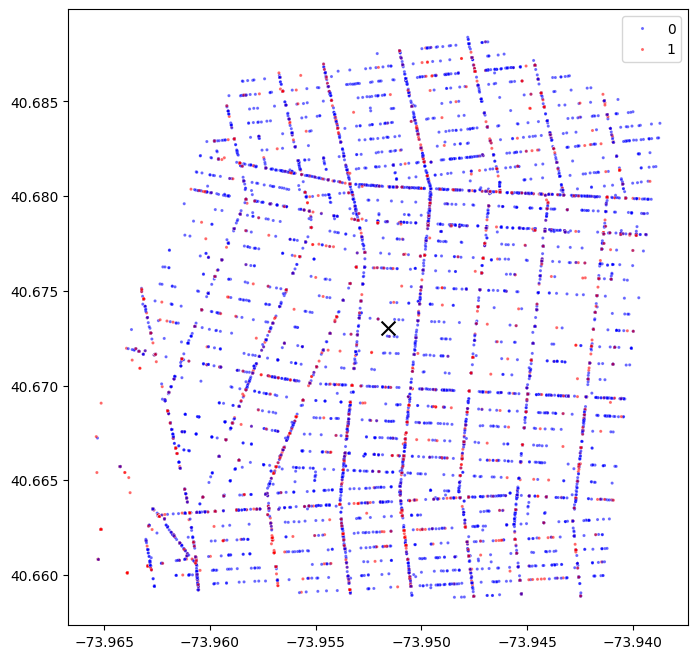

In [50]:
# Filter the dataframe for the 'Manhattan_4' cluster
cluster_data = df_clustered[df_clustered['CLUSTER NAME'] == 'Brooklyn_2']
latitudes = cluster_data['LATITUDE'].values
longitudes = cluster_data['LONGITUDE'].values
fatality_or_injury = cluster_data['HAS_FATALITY_OR_INJURY'].values

# Get the centroid coordinates for 'Manhattan_4'
centroid_lat, centroid_lon = centroid_map.get('Brooklyn_2', (None, None))

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the cluster points with colors based on HAS_FATALITY_OR_INJURY
sns.scatterplot(x=longitudes, y=latitudes, hue=fatality_or_injury, palette={False: 'blue', True: 'red'}, legend='full', s=5, alpha=0.6)


# Plot the centroid
if centroid_lat is not None and centroid_lon is not None:
    plt.scatter(centroid_lon, centroid_lat, color='black', marker='x', s=100, label='Manhattan_2 Centroid')



# Show the plot
plt.show()

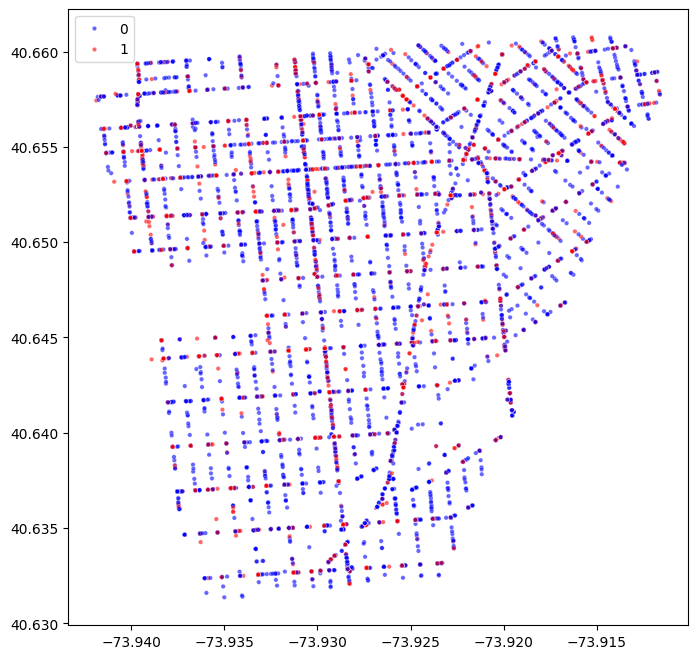

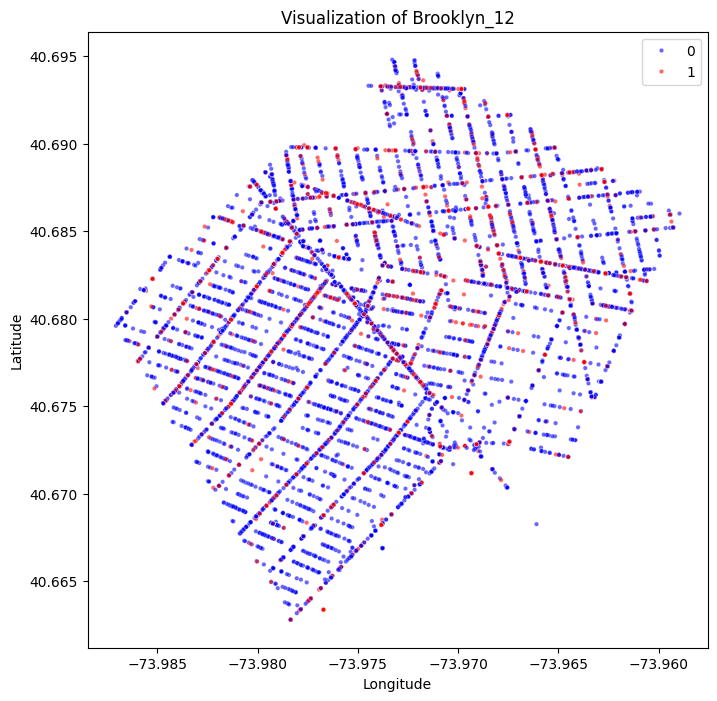

In [51]:
# Filter the dataframe for the 'Manhattan_4' cluster
cluster_data = df_clustered[df_clustered['CLUSTER NAME'] == 'Brooklyn_11']
latitudes = cluster_data['LATITUDE'].values
longitudes = cluster_data['LONGITUDE'].values
fatality_or_injury = cluster_data['HAS_FATALITY_OR_INJURY'].values

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the cluster points with colors based on HAS_FATALITY_OR_INJURY
sns.scatterplot(x=longitudes, y=latitudes, hue=fatality_or_injury, palette={0: 'blue', 1: 'red'}, legend='full', s=10, alpha=0.6)




# Filter the dataframe for the 'Manhattan_4' cluster
cluster_data = df_clustered[df_clustered['CLUSTER NAME'] == 'Brooklyn_12']
latitudes = cluster_data['LATITUDE'].values
longitudes = cluster_data['LONGITUDE'].values
fatality_or_injury = cluster_data['HAS_FATALITY_OR_INJURY'].values

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the cluster points with colors based on HAS_FATALITY_OR_INJURY
sns.scatterplot(x=longitudes, y=latitudes, hue=fatality_or_injury, palette={0: 'blue', 1: 'red'}, legend='full', s=10, alpha=0.6)



# Add title and labels
plt.title("Visualization of Brooklyn_12")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')

# Show the plot
plt.show()
    

In [52]:
cols_to_drop = ['CLUSTER',]
df_clustered = df_clustered.drop(columns = cols_to_drop)

In [53]:

# Format: 'old_name': 'new_name'
columns_to_rename = {
    'SUBURB': 'BOROUGH',
    'POSTCODE': 'ZIP CODE',
    'MONTH' : 'CRASH MONTH', 
    'WEEK' : 'CRASH WEEK',
    'SEASON' : 'CRASH SEASON',
    'CLUSTER_NAME' : 'CLUSTER NAME',
    'day_of_week' : 'CRASH DAY'
}

# Rename the columns
df_clustered.rename(columns=columns_to_rename, inplace=True)

In [54]:
new_order = ['Unnamed: 0', 'COLLISION_ID',
            'CRASH DATE', 'CRASH TIME', 'CRASH HOUR', 'CRASH DAY', 'CRASH WEEK', 'CRASH MONTH',  'CRASH SEASON',  'is_weekend', 'is_holiday', 'holiday_name', 
            'LATITUDE', 'LONGITUDE',  'ROAD', 'NEIGHBOURHOOD', 'BOROUGH', 'ZIP CODE', 'CLUSTER NAME',
            'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'VEHICLE_COUNT_ESTIMATE', 'HAS_FATALITY', 'HAS_INJURY', 'HAS_FATALITY_OR_INJURY',
            'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
            'DRIVER_LICENSE_STATUS_1', 'DRIVER_LICENSE_STATUS_2', 'DRIVER_LICENSE_STATUS_3', 'DRIVER_LICENSE_STATUS_4', 'DRIVER_LICENSE_STATUS_5',
            'DRIVER_SEX_1', 'DRIVER_SEX_2', 'DRIVER_SEX_3', 'DRIVER_SEX_4', 'DRIVER_SEX_5',
            'POINT_OF_IMPACT_1', 'POINT_OF_IMPACT_2', 'POINT_OF_IMPACT_3', 'POINT_OF_IMPACT_4', 'POINT_OF_IMPACT_5',
            'PRE_CRASH_1', 'PRE_CRASH_2', 'PRE_CRASH_3', 'PRE_CRASH_4','PRE_CRASH_5',
            'PUBLIC_PROPERTY_DAMAGE_1', 'PUBLIC_PROPERTY_DAMAGE_2', 'PUBLIC_PROPERTY_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE_4', 'PUBLIC_PROPERTY_DAMAGE_5',
            'PUBLIC_PROPERTY_DAMAGE_TYPE_1', 'PUBLIC_PROPERTY_DAMAGE_TYPE_2', 'PUBLIC_PROPERTY_DAMAGE_TYPE_3', 'PUBLIC_PROPERTY_DAMAGE_TYPE_4', 'PUBLIC_PROPERTY_DAMAGE_TYPE_5', 
            'STATE_REGISTRATION_1', 'STATE_REGISTRATION_2', 'STATE_REGISTRATION_3', 'STATE_REGISTRATION_4', 'STATE_REGISTRATION_5',
            'TRAVEL_DIRECTION_1', 'TRAVEL_DIRECTION_2', 'TRAVEL_DIRECTION_3', 'TRAVEL_DIRECTION_4', 'TRAVEL_DIRECTION_5',
            'VEHICLE_DAMAGE_1', 'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'VEHICLE_DAMAGE_4', 'VEHICLE_DAMAGE_5',
            'VEHICLE_MAKE_1', 'VEHICLE_MAKE_2', 'VEHICLE_MAKE_3', 'VEHICLE_MAKE_4', 'VEHICLE_MAKE_5',
            'clouds','dewpt','dhi','dni','ghi','max_dhi','max_dni','max_ghi','max_temp','max_temp_ts','max_uv','max_wind_dir','max_wind_spd','max_wind_spd_ts','min_temp','min_temp_ts','precip','precip_gpm','pres','revision_status','rh','slp','snow','snow_depth','solar_rad','t_dhi','t_dni','t_ghi','t_solar_rad','temp','ts','wind_dir','wind_gust_spd', 'wind_spd'                                
            ] 


df_clustered = df_clustered[new_order]

In [55]:
df_clustered.dtypes

Unnamed: 0                                int64
COLLISION_ID                              int64
CRASH DATE                       datetime64[ns]
CRASH TIME                               object
CRASH HOUR                                int64
CRASH DAY                                object
CRASH WEEK                               UInt32
CRASH MONTH                               int32
CRASH SEASON                             object
CRASH SEASON                             object
is_weekend                                 bool
is_holiday                                 bool
holiday_name                             object
LATITUDE                                float64
LONGITUDE                               float64
ROAD                                     object
NEIGHBOURHOOD                            object
BOROUGH                                  object
ZIP CODE                                float64
CLUSTER NAME                             object
NUMBER OF PERSONS INJURED               